In [152]:
from fastai.vision import *
from sklearn.model_selection import train_test_split

from fastai_bayesian.custom_dropout import CustomDropout, switch_custom_dropout, convert_layers
from fastai_bayesian.metrics import (entropy, BALD, uncertainty_best_probability,
                      get_preds_sample, plot_hist_groups, top_k_uncertainty)

import seaborn as sns

In [153]:
class ImageActiveLearner:
    def __init__(self,path,train_df,get_model,acq_fn=None,label_fn=None,**kwargs):
        """Initialiaze the Learner with the train and test data, and create it with the given params. 
        data_params are the parameters of the TabularDatabunch.
        learn_params are the parameters of the tabular learner other than the Databunch.
        acq_fn is the acq_fn to use. Its signature is :
        acq_fn(learn:Learner,k)
        
        label_fn()
        
        """
        self.path = path
        
        # We store the functions we will use
        self.acq_fn = acq_fn
        self.label_fn = label_fn
        self.get_model = get_model
        
        # Create the Learner
        self.add_learn(train_df,**kwargs)
    
    @classmethod
    def create_databunch(cls,df,valid_pct = 0.2,bs = 32,size = 28,gray = True):
        path = Path("/")

        tfms = get_transforms(do_flip = False)

        data = (ImageList.from_df(df,path)
                .split_by_rand_pct(valid_pct=valid_pct,seed=42)
                .label_from_df()
                .transform(tfms,size = size)
                .databunch(bs = bs)
                .normalize())

        def get_one_channel(batch):
            x,y = batch
            return x[:,0,:,:].unsqueeze(1),y
        get_one_channel._order = 99

        if gray:
            data.add_tfm(get_one_channel)
        data.path = Path()

        return data
        
    def add_learn(self,train_df,**kwargs):

        # Create a Learner 
        path = self.path
        train_data = ImageActiveLearner.create_databunch(df=train_df, **kwargs)
        model = self.get_model()
        learn = Learner(train_data,model,metrics=accuracy)
        
        # Add the Custom Dropout to do MC Dropout
        get_args = lambda dp : {"p" : dp.p}
        convert_layers(learn.model,nn.Dropout,CustomDropout,get_args)
        switch_custom_dropout(learn.model,True)
        
        self.learn = learn
        
    def fit(self,n_epoch,lr):
        """Train the model using one cycle policy and with the training params"""
        n_epoch = listify(n_epoch)
        lr = listify(lr)
        
        for n,l in zip(n_epoch,lr):
            self.learn.fit_one_cycle(n, l)
    
    def inspect(self):
        """Inspect the results of the learning"""
        pass
    
    def acquire(self,acq_df,k,bs=512):
        """Get indexes of the k most interesting labels to acquire from the test set"""
        
        # We add a acquisition Databunch
        acq_data = ImageActiveLearner.create_databunch(df=acq_df, valid_pct=0.,bs=bs)
        idx = self.acq_fn(self.learn,acq_data,k)
        
        return idx
    
    def validate(self,metric,test_df,bs=512,MC_dropout=False):
        """Return a validation score on the test set"""
        learn = self.learn
        
        test_data = ImageActiveLearner.create_databunch(df=test_df, valid_pct=0.,bs=bs)
        
        learn.data = test_data
        
        if MC_dropout:
            preds,y = get_preds_sample(learn,DatasetType.Fix)
            pred = preds.mean(dim=0)
        else:
            pred,y = learn.get_preds(DatasetType.Fix)
        
        score = metric(pred,y)
        return score
        
    def label(self,idx,acq_df):
        """Label the indexes of the acquisition dataset"""
        df_to_label = acq_df.iloc[idx]        
        labeled_df = self.label_fn(df_to_label)
        return labeled_df
    
    @classmethod
    def transfer_rows(cls,train_df,acq_df,idx):
        """Transfer the rows of the acq_df to the train_df"""
        rows = acq_df.iloc[idx]

        train_df = pd.concat([train_df,rows])
        acq_df = acq_df.drop(acq_df.index[idx])
        
        return train_df, acq_df

In [154]:
from torch.distributions import Bernoulli

class DropLinear(nn.Module):
    def __init__(self, in_features, out_features, dp=0.):
        """Wrapper of a linear layer with a dropout module"""
        super(DropLinear, self).__init__()

        self.dropout = CustomDropout(dp)
        self.W = nn.Linear(in_features=in_features,out_features=out_features)
        
        self._mask = None
    
    @classmethod
    def sample_mask(cls,p,n):
        """Returns the mask of the weights"""
        
        bn = Bernoulli(p)
        mask = bn.sample((n,1))
        
        return mask
    
    def sample(self):
        """Sample a mask from the dropout module and the weight matrix"""
        p = 1 - self.dropout.p
        shape = self.W.weight.data.shape
        n = shape[0]
        
        mask = DropLinear.sample_mask(p,n)
        
        return mask
    
    def topk_sample(self,n:int,k:int,p:float):
        """Sample a mask where only the top k weights of the matrix are considered for the dropout.
        The other weights will be necessarily dropped.
        
        Args:
            n: Total number of weights
            k: Number of weights with the best magnitude to consider for the dropout
            p: Probability to keep a neuron
            
        Returns:
            A mask where only the top k neurons will be used to sample from
        """
        
        # We compute the indexes of the rows with highest norm
        norm = self.W.weight.data.norm(dim=1)
        idx = torch.topk(norm,k).indices
        
        # We create a mask with only zeros first
        mask = torch.zeros(n)
        
        # Then we eventually allow the top k neurons to be kept depending on p
        small_mask = DropLinear.sample_mask(p,k).view(-1)
        mask[idx] = small_mask
        
        return mask 
        
    def set_mask(self,mask):
        self._mask = mask
        
    def remove_mask(self):
        self._mask = None
    
    def forward(self, x):
        if torch.is_tensor(self._mask):
            # We fix the weights with respect to the mask
            weight = self.W.weight.data
            bias = self.W.bias.data
            
            # We normalize as during training by dividing by the probability to keep a neuron
            dp = self.dropout.dp
            p = 1 - dp
            
            # We apply our mask to the weights 
            masked_weight = self._mask.to(weight.device) * weight
            z = F.linear(x,masked_weight,bias)
            z = z / p
        else:
            # We keep the stochasticity here so we do as usual
            z = self.W(x)
            z = self.dropout(z)
        return z

In [156]:
def get_model():
    model = nn.Sequential(
        nn.Flatten(),
        DropLinear(784,512,0.7),
        nn.ReLU(),
        DropLinear(512,512,0.7),
        nn.ReLU(),
        DropLinear(512,512,0.7),
        nn.ReLU(),
        nn.Linear(512,10)
    )
    return model

In [157]:
def train_test_split_image(train_size):
    # Create two data bunchs, one for training the unsupervised model, one for testing
    # the results of the semi supervised model
    
    # We first load the whole data set 
    path = untar_data(URLs.MNIST)
    tfms = get_transforms(do_flip = False)
    data = (ImageList.from_folder(path/"training")
            .split_none()
            .label_from_folder()
            .transform()
            .databunch())

    # We then randomly select train_size samples from the whole MNIST and put in train
    # for the unsupervised, and semi supervised training, and the rest will be used 
    # as a test set for the semi supervised model evaluation
    
    n = len(data.train_ds.x.items)
    
    # We create two data frames which will be used to create the data bunches
    train_idx = np.random.choice(n,train_size,replace = False)
    x_train,y_train = data.train_ds.x.items[train_idx],data.train_ds.y.items[train_idx]
    train_df = pd.DataFrame({"name":x_train,"label":y_train})
    
    test_idx = np.array(list(set(np.arange(n)) - set(train_idx)))
    x_test,y_test = data.train_ds.x.items[test_idx],data.train_ds.y.items[test_idx]
    test_df = pd.DataFrame({"name" : x_test,"label":y_test})
    
    return train_df, test_df

In [158]:
path = untar_data(URLs.MNIST)

In [159]:
total_train_size = 50000

train_df, test_df = train_test_split_image(total_train_size)

In [160]:
data = ImageActiveLearner.create_databunch(train_df,bs=512)

In [161]:
model = get_model()
learn = Learner(data,model,metrics=accuracy)

In [ ]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time


In [69]:
learn.fit_one_cycle(5,1e-2/2)

epoch,train_loss,valid_loss,accuracy,time
0,1.355102,0.563965,0.817800,00:11
1,0.949814,0.578249,0.825700,00:10
2,0.805777,0.464609,0.867700,00:11
3,0.655255,0.348355,0.901000,00:10
4,0.566773,0.327698,0.910500,00:10


In [71]:
learn.fit_one_cycle(3,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.520264,0.327990,0.911600,00:12
1,0.504233,0.292823,0.916500,00:11
2,0.483160,0.277825,0.919700,00:11


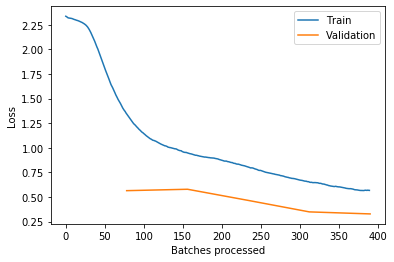

In [70]:
learn.recorder.plot_losses()

In [72]:
preds,y = get_preds_sample(learn)

In [73]:
pred = preds.mean(dim=0)
accuracy(pred,y)

tensor(0.9620)

In [25]:
def sample_model(model,set_mask=True):
    """Sample a mask for each Droplinear and set it"""
    masks = []
    for m in model:
        if isinstance(m,DropLinear):
            mask = m.sample()
            if set_mask:
                m.set_mask(mask) 
            masks.append(mask)
    return masks

def get_mask_preds(learn):
    """Sample a mask and get preds"""
    mask = sample_model(learn.model)
    pred,y = learn.get_preds(ds_type=DatasetType.Fix)
    pred = pred.view((1,) + pred.shape)
    return mask,pred

def remove_lowest(masks,preds,score_fn,return_score=False):
    """Removes the lowest mask for a given score function"""
    scores = score_fn(preds)
    idx = scores.argmin().item()
    
    del masks[idx]
    del preds[idx]
    
    if return_score:
        return scores

def kls(preds):
    """Return the KL between the overall mean and the means without each mask"""
    mean_pred = torch.cat(preds).mean(dim=0)
    pred = torch.cat(preds)
    means_pred = (mean_pred[None] * T - pred)/ (T-1)

    logs = torch.log(mean_pred[None] / means_pred)

    kls = torch.einsum("tic,ic -> t",logs,mean_pred)
    
    return kls    

In [ ]:
def union_mask(mask1,mask2):
    u = mask1 + mask2
    u = torch.clamp(u,0,1)
    return u

def intersection_mask(mask1,mask2):
    return mask1 * mask2

def iou(mask1,mask2):
    i = intersection_mask(mask1,mask2).sum()
    u = union_mask(mask1,mask2).sum()
    return i/u

In [26]:
mask,pred = get_mask_preds(learn)

In [28]:
torch.cat(mask)

torch.Size([1536, 1])

In [53]:
masks[:,0]

torch.Size([1536, 1])

In [76]:
current_masks = []
current_preds = []

mask,pred = get_mask_preds(learn)

current_masks.append(mask)
current_preds.append(pred)

T = 1
n_iterations = 10

total_mask = torch.cat(mask)

for t in range(T):
    masks = []
    preds = []
    for i in range(n_iterations):
        mask,pred = get_mask_preds(learn)
        mask = torch.cat(mask)
        
        masks.append(mask)
        preds.append(pred)
    
    import pdb
    pdb.set_trace()
    
    scores = kls(preds)
    masks = torch.cat(masks,dim=1)
    
    u = torch.clamp(masks + total_mask,0,1).sum(dim=0)
    i = (total_mask * masks).sum(dim=0)
    
    iou = i / u
    
    final_score = iou * scores
    best_idx = final_score.argmax().item()
    
    best_mask = masks[:,best_idx][:,None]
    best_pred = preds[best_idx]
    
    total_mask = torch.clamp(total_mask + best_mask,0,1)
    
    current_masks.append(best_mask)
    current_preds.append(best_pred)

> <ipython-input-76-f9e1faf63e42>(27)<module>()
-> scores = kls(preds)
(Pdb) n
> <ipython-input-76-f9e1faf63e42>(28)<module>()
-> masks = torch.cat(masks,dim=1)
(Pdb) scores
tensor([-inf, -inf, nan, -inf, -inf, -inf, -inf, -inf, -inf, -inf])
(Pdb) scores
tensor([-inf, -inf, nan, -inf, -inf, -inf, -inf, -inf, -inf, -inf])
(Pdb) preds
[tensor([[[0.0923, 0.0525, 0.0743,  ..., 0.0816, 0.2460, 0.1618],
         [0.0544, 0.0344, 0.0347,  ..., 0.0287, 0.5146, 0.1237],
         [0.1596, 0.0220, 0.0573,  ..., 0.0573, 0.2662, 0.1689],
         ...,
         [0.0866, 0.0622, 0.0824,  ..., 0.0648, 0.2785, 0.1392],
         [0.0669, 0.0461, 0.0522,  ..., 0.0432, 0.3651, 0.1524],
         [0.0519, 0.0390, 0.0324,  ..., 0.0228, 0.5522, 0.1034]]]), tensor([[[0.0738, 0.0563, 0.0492,  ..., 0.0659, 0.2965, 0.1893],
         [0.0605, 0.0365, 0.0434,  ..., 0.0304, 0.5244, 0.1076],
         [0.1691, 0.0268, 0.0551,  ..., 0.0395, 0.2681, 0.1597],
         ...,
         [0.0801, 0.0588, 0.0671,  ..., 0.0563, 

BdbQuit: 

In [75]:
total_mask.mean()

tensor(0.3151)

In [30]:
T = 5
masks = []
preds = []

for t in range(T):
    mask,pred = get_mask_preds(learn)
    mask = torch.cat(mask)
    masks.append(mask)
    preds.append(pred)

In [33]:
mask,_ = get_mask_preds(learn)
mask = torch.cat(mask)

In [42]:
u = torch.clamp(masks + mask,0,1).sum(dim=0)

In [43]:
i = (mask * masks).sum(dim=0)

In [48]:
i / u

tensor([0.4085, 0.4116, 0.4034, 0.3728, 0.4077])

In [34]:
masks = 

In [448]:


T = 5
mean = []
low = []
high = []
std = []

masks = []
preds = []
for t in range(T):
    mask,pred = get_mask_preds(learn)
    masks.append(mask)
    preds.append(pred)
    
n_iterations = 60

for i in range(n_iterations):
    scores = remove_lowest(masks,preds,kls,True)
    mean.append(scores.mean().item())
    low.append(scores.min().item())
    high.append(scores.max().item())
    std.append(scores.std().item())
    
    mask,pred = get_mask_preds(learn)
    masks.append(mask)
    preds.append(pred)

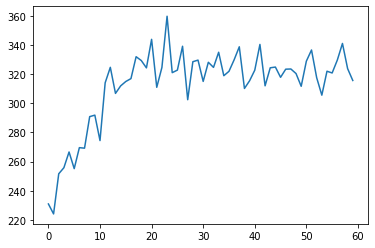

In [454]:
plt.plot(mean)

In [417]:
import itertools

In [457]:
p = torch.cat(preds).mean(dim=0)

In [458]:
accuracy(p,y)

tensor(0.9658)

In [427]:
_,y = learn.get_preds(DatasetType.Fix)

In [429]:
p,y = get_preds_sample(learn,DatasetType.Fix)

In [431]:
p = (p).mean(dim=0)

In [434]:
for m in learn.model:
    if isinstance(m,DropLinear):
        m.remove_mask()

In [437]:
learn.validate(learn.dl(DatasetType.Fix))

[0.12555529, tensor(0.9631)]

In [62]:
total = torch.zeros(1536,1)

for mask in masks:
    total += torch.cat(mask)

total = torch.clamp(total,0,1)

total.mean()

TypeError: cat(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

In [395]:
kls

tensor([39.3916, 32.5208, 41.0234, 61.9734, 45.3171, 76.7213, 58.6875, 59.2673,
        30.5528, 55.3150])

In [398]:
del preds[idx]

In [240]:
for tfm in learn.data.train_dl.tfms:
    x,y = tfm((x,y))

In [243]:
learn.model(x)

RuntimeError: Expected object of device type cuda but got device type cpu for argument #2 'mat1' in call to _th_addmm

In [217]:
l = DropLinear(20,10,0.5)

In [184]:
mask = l.sample()

In [185]:
l.set_mask(mask)

In [186]:
mask

tensor([[1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.]])

In [197]:
l.remove_mask()

In [141]:
import types

In [155]:
torch.is_nonzero(None)

TypeError: is_nonzero(): argument 'input' (position 1) must be Tensor, not NoneType

In [152]:
x = torch.randn(20)